In [17]:
import os
import sys
sys.path.append('C:\\Users\\dhruv\\Anaconda3\\envs\\testPanorama\\Lib\\site-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot
import random

In [18]:
!export PATH=/Library/TeX/texbin:$PATH

'export' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
feature_extractor = 'sift' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

In [64]:
coordinates1 = []
coordinates2 = []
coordinates = []
def click_event(event, x, y, flags, params):
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(img, str(x) + ',' +
#                     str(y), (x,y), font,
#                     1, (255, 0, 0), 2)
#         cv2.imshow('image', img)
        if params == 1:
            coordinates1.append([x,y])
        elif params == 2:
            coordinates2.append([x,y])
        coordinates.append([x,y])
            
    # checking for right mouse clicks     
    if event==cv2.EVENT_RBUTTONDOWN:
  
        # displaying the coordinates
        # on the Shell
        print(x, ' ', y)
  
        # displaying the coordinates
        # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         b = img[y, x, 0]
#         g = img[y, x, 1]
#         r = img[y, x, 2]
#         cv2.putText(img, str(b) + ',' +
#                     str(g) + ',' + str(r),
#                     (x,y), font, 1,
#                     (255, 255, 0), 2)
#         cv2.imshow('image', img)
        if params == 1:
            coordinates1.append([x,y])
        elif params == 2:
            coordinates2.append([x,y])
        coordinates.append([x,y])


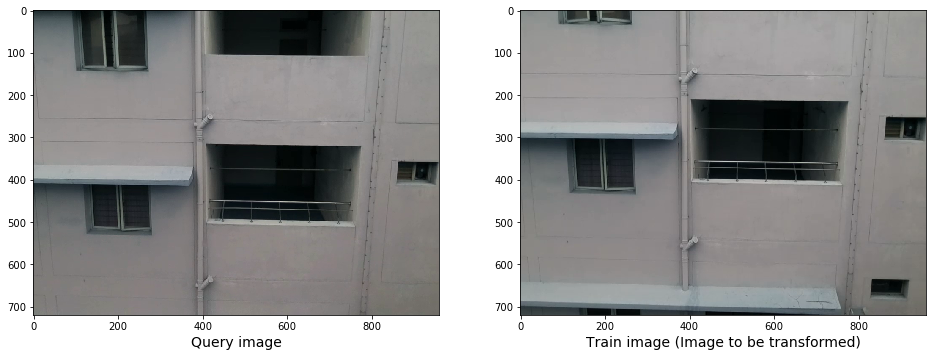

In [65]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
imgPath = "F:\\IIIT-H Work\\win_det_heatmaps\\datasets\\IIIT-H Dataset\\Bakul-All\\005\\images\\"

img1 = cv2.imread(imgPath + str('Bakul_005_000560.png'), 1)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

img2 = cv2.imread(imgPath + str('Bakul_005_000640.png'), 1)
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(img2, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(img1, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

118   304
128   436
276   434
271   303
Bounding Box coords for image1 :  [[[118 304]
  [128 436]
  [276 434]
  [271 303]]]


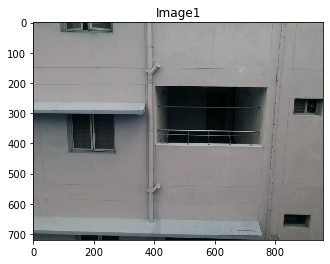

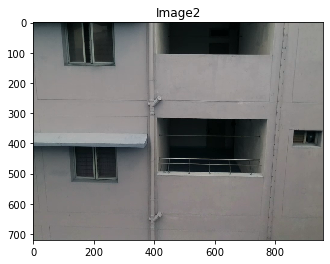

In [66]:
img1 = np.copy(img1)
plt.figure()
plt.title('Image1')
plt.imshow(img1)

img2 = np.copy(img2)
plt.figure()
plt.title('Image2')
plt.imshow(img2)

#setting mouse hadler for the image
#and calling the click_event() function
cv2.imshow('image1',img1)
cv2.setMouseCallback('image1', click_event, 1)

#wait for a key to be pressed to exit
cv2.waitKey(0)
#close the window
cv2.destroyAllWindows()

# print(coordinates1)
# print("\n")

coords = np.array(coordinates1)
coords = np.reshape(coords,(coords.shape[0]//4 , 4, coords.shape[1]))
print("Bounding Box coords for image1 : ", coords)

In [67]:
coordinates = []
cv2.imshow('image2',img2)
cv2.setMouseCallback('image2', click_event, 2)

#wait for a key to be pressed to exit
cv2.waitKey(0)
#close the window
cv2.destroyAllWindows()

coords2 = np.array(coordinates2)
coords2 = np.reshape(coords2,(coords2.shape[0]//4 , 4, coords2.shape[1]))
print("Bounding Box coords for image2 : ", coords2)

98   1
107   145
276   145
269   0
124   412
129   526
280   529
273   415
Bounding Box coords for image2 :  [[[ 98   1]
  [107 145]
  [276 145]
  [269   0]]

 [[124 412]
  [129 526]
  [280 529]
  [273 415]]]


In [68]:
def calculateRange(coordinates, padding, imageShape):
    minX = maxX = coordinates[0][0]
    minY = maxY = coordinates[0][1]
    startX = startY = endX = endY = 0
    h,w,c = imageShape
    for i in range(len(coordinates)):
        if minX > coordinates[i][0]:
            minX = coordinates[i][0]
        if maxX < coordinates[i][0]:
            maxX = coordinates[i][0]

        if minY > coordinates[i][1]:
            minY = coordinates[i][1]
        if maxY < coordinates[i][1]:
            maxY = coordinates[i][1]
    
    if (minX - padding < 0):
        startX = 0
    else:
        startX = minX - padding
    if (minY - padding < 0):
        startY = 0
    else:
        startY = minY - padding
    if (maxX + padding >= w):
        endX = w - 1
    else:
        endX = maxX + padding
    if (maxY + padding >= h):
        endY = h - 1
    else:
        endY = maxY + padding
    return startX, endX, startY, endY

def prepareBinaryMask(binary_img, coordinates):
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], 5, (720,960,3))
        binary_img[startY:endY, startX:endX] = 1
    return binary_img

def mapToPick(coordinates):
    pick = []
    for i in range(coordinates.shape[0]):
        startX, endX, startY, endY = calculateRange(coordinates[i], 5, (720,960,3))
        pick.append([startX, startY, endX, endY])
    return pick

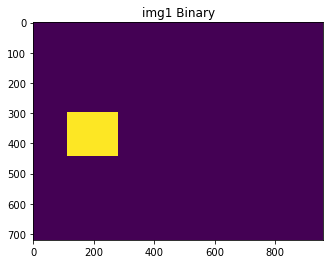

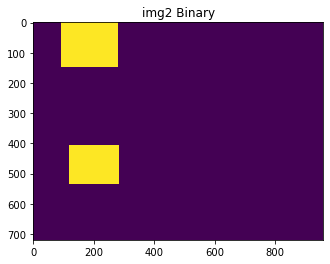

In [69]:
## Preparing Binary Mask and mapping bounding box coordinates

ret, img1_binary = cv2.threshold(img1_gray, 255, 255, cv2.THRESH_BINARY)
ret, img2_binary = cv2.threshold(img2_gray, 255, 255, cv2.THRESH_BINARY)
prepareBinaryMask(img1_binary, coords)
prepareBinaryMask(img2_binary, coords2)
plt.figure()
plt.title('img1 Binary')
plt.imshow(img1_binary)
plt.show()
plt.title('img2 Binary')
plt.imshow(img2_binary)
plt.show()

pick = mapToPick(coords)
pick2 = mapToPick(coords2)







# SIFT Feature Matching on Bounding Box Descriptors(Window masks):




In [70]:
def detectAndDescribe(image, mask, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, mask)
#     kps = np.float32([kp.pt for kp in kps])
    return (kps, features)

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    print(rawMatches)
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        print('m: ' + str(m) + ' n: ' + str(n))
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [71]:
kpsA, featuresA = detectAndDescribe(img1_gray, img1_binary, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(img2_gray, img2_binary, method=feature_extractor)
print('featuresA: ')
print(featuresA.shape)
print('featuresB: ')
print(featuresB)
print(len(kpsA))
print(kpsB)

featuresA: 
(28, 128)
featuresB: 
[[ 38.  20.   5. ...   0.   0.   6.]
 [ 24.  10.  37. ...   0.   0.   8.]
 [146.   0.   0. ...   3.   0.   2.]
 ...
 [  5.   0.   0. ...   0.   4.  31.]
 [  0.   0.   1. ...   0.   4.  33.]
 [ 38.   0.   1. ...   0.   0.   1.]]
28
[<KeyPoint 000002B3139D2960>, <KeyPoint 000002B3139D2C60>, <KeyPoint 000002B3139D2C90>, <KeyPoint 000002B31622BED0>, <KeyPoint 000002B31622BBA0>, <KeyPoint 000002B31622BA50>, <KeyPoint 000002B31622BA80>, <KeyPoint 000002B31622BD20>, <KeyPoint 000002B31622B570>, <KeyPoint 000002B31622B4B0>, <KeyPoint 000002B31622BFC0>, <KeyPoint 000002B31622BB70>, <KeyPoint 000002B31622B9C0>, <KeyPoint 000002B31622BBD0>, <KeyPoint 000002B31622BC60>, <KeyPoint 000002B31622B180>, <KeyPoint 000002B31622BA20>, <KeyPoint 000002B31622B7B0>, <KeyPoint 000002B31622BEA0>, <KeyPoint 000002B31622B960>, <KeyPoint 000002B31622B6C0>, <KeyPoint 000002B31622B720>, <KeyPoint 000002B31622B060>, <KeyPoint 000002B31622BC90>, <KeyPoint 000002B31622B6F0>, <KeyPoint

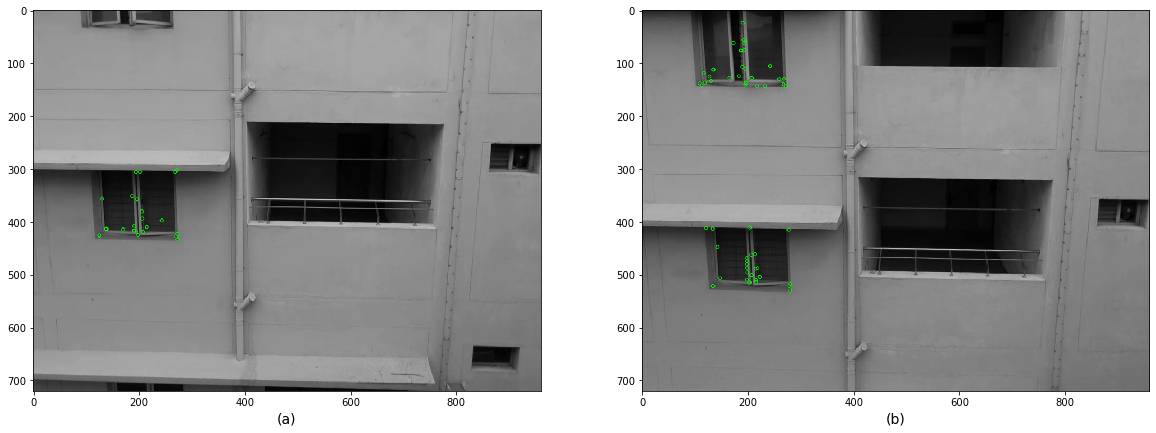

In [72]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img1_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(img2_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

Using: bf feature matcher
Raw matches (Brute force): 25


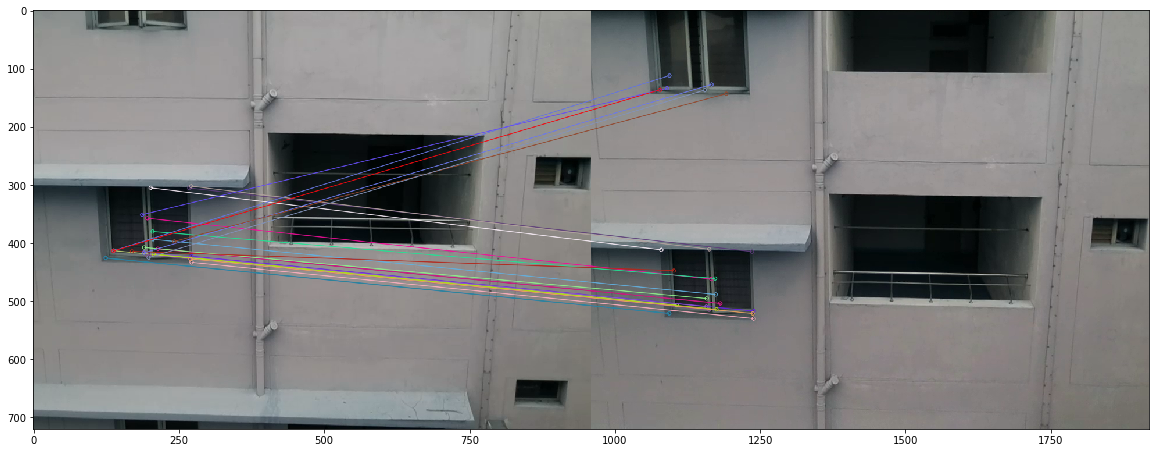

In [73]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()







# Homography Calculation and Outlier Rejection





In [74]:
#
# Computers a homography from 4-correspondences
#
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


#
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):
    
    print("correspondence: ", correspondence)
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    print("estimatep2: ", estimatep2)
    print(estimatep2.item(2))
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


#
#Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

# This draws matches and optionally a set of inliers in a different color
# Note: I lifted this drawing portion from stackoverflow and adjusted it to my needs because OpenCV 2.4.11 does not
# include the drawMatches function
def drawMatches(img1, kp1, img2, kp2, matches, inliers = None):
    print(img1.shape)
    print(img2.shape)
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    print(np.dstack([img1, img1, img1]).shape)
    out[:rows1,:cols1,:] = img1 #np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = img2 #np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:
                    inlier = True

        # Draw a small circle at both co-ordinates
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points, draw inliers if we have them
        if inliers is not None and inlier:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 255, 0), 1)
        elif inliers is not None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 0, 255), 1)

        if inliers is None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)

    return out

In [83]:
## Calculating homography and rejecting outliers

correspondenceList = []
estimation_thresh = 0.60
for match in matches:
    (x1, y1) = kpsA[match.queryIdx].pt
    (x2, y2) = kpsB[match.trainIdx].pt
    correspondenceList.append([x1, y1, x2, y2])
    
    
corrs = np.matrix(correspondenceList)

#run ransac algorithm
finalH, inliers = ransac(corrs, estimation_thresh)
print("Final homography: ", finalH)
print("Final inliers count: ", len(inliers))
print("Inliers: " +  str(inliers))

img3 = drawMatches(img1,kpsA,img2,kpsB, matches, inliers)
plt.figure(figsize=(15,15))
plt.imshow(img3)
plt.show()

# for inlier in inliers:
#     print(inlier[0][0])

## Converting to numpy array = INLIERS
inliers_Arr = np.array(inliers)
inliers = np.squeeze(inliers_Arr, axis = 1).tolist()
print(inliers)


correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 69.22251353]
 [158.42387327]
 [  0.31139247]]
0.31139247157964334
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 69.22251353]
 [158.42387327]
 [  0.31139247]]
0.31139247157964334
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[53.33353612]
 [79.94638992]
 [ 0.19281445]]
0.19281444605867937
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 73.57888514]
 [285.91844539]
 [  0.54899663]]
0.548996633740232
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[ 71.1003985 ]
 [186.42601119]
 [  0.36164832]]
0.36164832439152406
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 69.45898688]
 [191.61947362]
 [  0.37513846]]
0.37513845732226514
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
es

correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[5.06060112e+00]
 [1.15293814e+01]
 [4.45220154e-03]]
0.004452201538066025
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-3.03829273]
 [ 0.73505437]
 [-0.05441092]]
-0.054410924292694895
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[1.07294112]
 [1.70605456]
 [0.00592432]]
0.005924318326347766
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[  3.79365457]
 [-15.06876982]
 [  0.16350574]]
0.16350574091268832
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[1.92884276]
 [3.57317331]
 [0.00723855]]
0.007238551372539703
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[ 3.39789723]
 [-7.89016918]
 [ 0.10857553]]
0.10857552881595245
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
esti

correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[ 81.8214599 ]
 [104.23635594]
 [  0.5216025 ]]
0.5216024951869378
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[64.96153978]
 [75.16056759]
 [ 0.52536727]]
0.5253672668312901
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ 99.55418119]
 [187.68264207]
 [  0.36579879]]
0.36579878968644763
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[85.31818535]
 [79.1974578 ]
 [ 0.61006111]]
0.6100611103445109
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 72.17253582]
 [146.0772247 ]
 [  0.35578339]]
0.35578339021239314
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[ 88.19502707]
 [101.49572453]
 [  0.55962196]]
0.5596219569888653
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimat

correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[ 503.05289883]
 [1302.10984379]
 [   2.55671659]]
2.5567165911206864
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[ 82.50682402]
 [763.41907221]
 [  1.5330725 ]]
1.5330724994348954
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[ 955.12636612]
 [1806.91155658]
 [   3.69729883]]
3.6972988256967474
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[ 552.82670031]
 [1391.4848749 ]
 [   2.66400524]]
2.6640052361766053
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[ 572.74387783]
 [1181.74929085]
 [   2.83980487]]
2.8398048664573556
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[ 78.00671113]
 [759.24342428]
 [  1.52125903]]
1.5212590300585789
Corr size:  25  NumInliers:  7 Max inliers:  7
correspondence:  

0.04476782263485535
Corr size:  25  NumInliers:  4 Max inliers:  7
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[12.93109894]
 [24.07548505]
 [ 0.04671436]]
0.04671435615924768
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[12.93109894]
 [24.07548505]
 [ 0.04671436]]
0.04671435615924768
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ 94.72722474]
 [175.76792159]
 [  0.34295411]]
0.34295410807630233
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-10.50353733]
 [-19.47905526]
 [ -0.03808771]]
-0.038087708190473024
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[3.08564323]
 [5.80019288]
 [0.01106973]]
0.011069732353597872
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[11.40907305]
 [21.22427923]
 [ 0.04122345]]
0.04122345281124984
correspondence:

estimatep2:  [[16.12325166]
 [38.53798132]
 [ 0.07633349]]
0.07633348842169496
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ -9.18304824]
 [-21.79758749]
 [ -0.04234282]]
-0.04234282382985022
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ 8.00933504]
 [20.43516509]
 [ 0.03700761]]
0.037007614654249066
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-17.69581935]
 [-42.2126046 ]
 [ -0.08214241]]
-0.08214240829572672
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[-3.72493924]
 [-8.06058097]
 [-0.0174891 ]]
-0.01748909897605566
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[23.15694751]
 [57.65596503]
 [ 0.10690926]]
0.10690925977710486
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -48.26740083]
 [-115.4861847 ]
 [  -0.22511627]]
-0.2251162660

correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 7.90994191]
 [17.9450375 ]
 [ 0.03562791]]
0.03562791280658706
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ 63.43156086]
 [140.56403739]
 [  0.29307611]]
0.2930761087930832
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-4.13691198]
 [-5.24482472]
 [-0.0122044 ]]
-0.012204397604730133
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[1.90914865]
 [5.29588324]
 [0.00922139]]
0.009221393636027031
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 8.04338885]
 [19.27195538]
 [ 0.03867276]]
0.038672760839685516
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 2.92755663]
 [10.06980491]
 [ 0.01987784]]
0.01987783962822265
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2: 

correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[  0.08376757]
 [-27.45589362]
 [ -0.0693612 ]]
-0.06936119822825748
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[  0.26901682]
 [-89.52155355]
 [ -0.22711069]]
-0.2271106938610422
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[  0.21834413]
 [-97.42474335]
 [ -0.24714509]]
-0.24714508628502563
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-0.47038903]
 [-2.6520054 ]
 [-0.00597697]]
-0.005976970959428285
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ -0.10271998]
 [-34.77370136]
 [ -0.08781245]]
-0.08781244815788714
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[0.2103182 ]
 [5.73304911]
 [0.01483327]]
0.014833266930051603
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]


correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 88.68977757]
 [305.06284562]
 [  0.60219541]]
0.6021954127746941
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[132.68767399]
 [300.27698982]
 [  0.61541484]]
0.6154148380776103
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[162.9894121 ]
 [301.34784332]
 [  0.58314186]]
0.5831418553856742
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[160.20479561]
 [302.60082617]
 [  0.57330295]]
0.5733029505771381
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 77.62813658]
 [307.06835176]
 [  0.59127013]]
0.5912701274876762
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[117.62415649]
 [303.5357634 ]
 [  0.5955368 ]]
0.5955367995099594
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
est

correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[-13.81879555]
 [-33.59596743]
 [ -0.06683438]]
-0.06683437623318256
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[-0.23105697]
 [-0.19268907]
 [-0.00171827]]
-0.0017182681788022736
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[-13.09235803]
 [-29.88842485]
 [ -0.06120734]]
-0.061207335815988695
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ -43.50786224]
 [-110.19451248]
 [  -0.21314631]]
-0.21314631415932583
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[ -47.38409627]
 [-121.33728513]
 [  -0.23352408]]
-0.23352407601561775
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-0.95811377]
 [-3.72311157]
 [-0.00714881]]
-0.007148806767312776
correspondence:  [[190.07272339 415.98751831 197.79521179 50

correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[28.63876372]
 [81.98509783]
 [ 0.1265921 ]]
0.1265921048872598
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[-5.91489455e+00]
 [ 2.10975321e+01]
 [ 4.71227607e-03]]
0.004712276074932742
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[ 68.88912272]
 [130.54981805]
 [  0.32302458]]
0.32302457713505883
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[31.65695511]
 [95.0162251 ]
 [ 0.11845426]]
0.11845426125765735
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[43.13205135]
 [44.41187429]
 [ 0.3314188 ]]
0.331418802213046
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[-6.35108355e+00]
 [ 2.08072139e+01]
 [ 2.00886275e-03]]
0.002008862752828855
Corr size:  25  NumInliers:  4 Max inliers:  14
correspondence

correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[25.14565806]
 [30.14645705]
 [ 0.12320871]]
0.12320870793900551
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[0.1264666 ]
 [0.32553836]
 [0.00063938]]
0.0006393815096927824
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[14.8154407 ]
 [17.2037538 ]
 [ 0.07257006]]
0.07257006364885943
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-8.06906323]
 [-9.38267911]
 [-0.03950768]]
-0.03950767729390525
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[4.17807447]
 [4.78783659]
 [0.02047033]]
0.02047032798598014
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[27.73697419]
 [32.04466445]
 [ 0.13584542]]
0.1358454214241004
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-37.

0.13839819954089516
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-1.79868338]
 [-2.27128973]
 [-0.009452  ]]
-0.009451998486199376
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[17.38296914]
 [39.71136415]
 [ 0.08370509]]
0.08370508738713056
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 54.37908901]
 [120.68925135]
 [  0.26337295]]
0.26337294850336956
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-5.73236599]
 [-8.75336579]
 [-0.03135616]]
-0.03135616066127067
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[0.42664618]
 [1.344842  ]
 [0.00300636]]
0.003006364202367884
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 56.0297537 ]
 [126.65918745]
 [  0.26828738]]
0.2682873837386427
correspondence:  [[190.67782593 416.61541748 206.80929565 127.

-0.0534857969332585
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[18.55100662]
 [17.35841068]
 [ 0.14816524]]
0.14816523889162947
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[ -7.64310868]
 [-18.23230213]
 [ -0.03547863]]
-0.035478625869641345
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[9.63752464]
 [4.42679185]
 [0.08870112]]
0.08870112489866111
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[42.98791971]
 [48.13500455]
 [ 0.32844123]]
0.32844123036504413
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -2.18748416]
 [-20.68866112]
 [  0.03917753]]
0.03917753338239616
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[-10.94452823]
 [-16.89506915]
 [ -0.08010565]]
-0.0801056545735237
correspondence:  [[271.58700562 302.27807617 202.85527039 41

correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-7.08873436e+00]
 [-5.27443502e+00]
 [-3.82960399e-03]]
-0.0038296039944354376
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[10.42748429]
 [15.63068541]
 [ 0.03769804]]
0.03769803680168882
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[26.51443026]
 [70.19074442]
 [ 0.14988363]]
0.14988363117322479
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[-2.37238509]
 [ 6.60288719]
 [ 0.0204365 ]]
0.020436502494546094
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 4.25716914]
 [18.95296506]
 [ 0.045447  ]]
0.045447000126553894
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[25.59813925]
 [66.12393802]
 [ 0.14148522]]
0.14148522388373297
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]

estimatep2:  [[ 2.98968925e+01]
 [-2.40570016e+02]
 [ 2.24472143e-01]]
0.22447214282420924
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-8.35147766e+00]
 [ 8.55887094e+01]
 [-7.40034655e-02]]
-0.07400346548398118
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ 6.9123594 ]
 [21.7886192 ]
 [ 0.04870797]]
0.0487079708860374
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 2.22876386e+01]
 [-2.26335890e+02]
 [ 1.62345861e-01]]
0.1623458613707225
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[3.83068628e+00]
 [3.42563667e+01]
 [2.39109010e-02]]
0.023910901020339548
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[10.98827848]
 [ 9.16363267]
 [ 0.08171495]]
0.08171495350728475
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[2.40690635]
 [1.48607118]
 [

 [  0.81813169]]
0.8181316885619438
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[171.84385748]
 [311.99198332]
 [  0.60746196]]
0.6074619589574181
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[174.28719833]
 [330.46089857]
 [  0.62384973]]
0.6238497252236138
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[158.37819925]
 [615.4380897 ]
 [  1.18171264]]
1.1817126350734157
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[162.38374738]
 [466.40925861]
 [  0.91452179]]
0.9145217862468095
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[149.30994606]
 [350.91830297]
 [  0.79949984]]
0.7994998371082572
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[164.72079489]
 [436.99591887]
 [  0.85298892]]
0.8529889226775528
correspondence:  [[205.404953   380.0835

estimatep2:  [[-22.92064059]
 [-66.89771118]
 [ -0.13204466]]
-0.13204465853437053
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 20.65476583]
 [106.66020605]
 [  0.16711496]]
0.16711496368373524
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[-27.71247313]
 [-71.19975671]
 [ -0.13960874]]
-0.13960874112900423
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[-16.99169983]
 [-64.36970766]
 [ -0.12747507]]
-0.12747507050609153
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-25.85037691]
 [-41.66694087]
 [ -0.08892585]]
-0.08892585046965096
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-33.59859234]
 [-84.72690944]
 [ -0.16302508]]
-0.16302507501263974
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[ 8.29329418]
 [31.74432282]
 [ 0.0382417 ]]
0.0382

correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[340.13464923]
 [784.38839431]
 [  1.68502266]]
1.68502266155501
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-36.44091452]
 [-84.18789473]
 [ -0.18234279]]
-0.18234279188947045
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[102.33116979]
 [230.99954745]
 [  0.44703293]]
0.44703293397998967
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[105.54800131]
 [239.86114671]
 [  0.48030632]]
0.48030632277171037
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[-5.27222710e-12]
 [ 6.90647539e-12]
 [-9.30366895e-14]]
-9.303668946358812e-14
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[146.30727316]
 [334.00354074]
 [  0.68399278]]
0.6839927826755774
correspondence:  [[272.32723999 422.64831543 279.50216675 516

correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 37.538216  ]
 [124.915852  ]
 [  0.24651621]]
0.2465162063384927
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[ 56.47522398]
 [128.92677421]
 [  0.2640241 ]]
0.2640240964530238
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ 57.15445615]
 [102.48575298]
 [  0.19715895]]
0.19715894767906428
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[53.26621519]
 [95.87827347]
 [ 0.17888001]]
0.1788800083513753
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 30.50593076]
 [118.54227311]
 [  0.22761494]]
0.2276149368522843
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ 45.40482256]
 [116.71830623]
 [  0.22874735]]
0.22874734976782385
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
esti

 [ 0.03784736]]
0.037847361496486376
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[11.22061501]
 [38.59512154]
 [ 0.07618694]]
0.07618694140761995
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[ 9.2368954 ]
 [24.52281675]
 [ 0.05092319]]
0.05092318832703935
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ -9.13248632]
 [-32.69719135]
 [ -0.06665276]]
-0.06665276122526098
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[-12.70623103]
 [-42.14704416]
 [ -0.08684873]]
-0.08684872870317761
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 8.59556125]
 [33.40128768]
 [ 0.06413435]]
0.06413435296750747
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ 3.6074159 ]
 [11.70644308]
 [ 0.02240446]]
0.02240446316357758
correspondence:  [[196.21142578 357.3612365

 [   8.15980184]]
8.15980184456477
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -632.67390522]
 [-2458.49252907]
 [   -4.72059129]]
-4.720591288463304
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[-27.7911311 ]
 [-70.58607265]
 [ -0.13717946]]
-0.13717945618183336
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[-1.09442657e+01]
 [-3.68603723e+01]
 [ 2.09368487e-02]]
0.020936848656702978
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ -471.25300528]
 [-1851.20036253]
 [   -3.46961495]]
-3.469614950139059
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[169.56549798]
 [642.70390016]
 [  1.41942334]]
1.4194233370824936
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ 609.21095346]
 [2467.54907223]
 [   4.66783889]]
4.667838887942601
correspondence

correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -5.51597673]
 [-13.55425933]
 [ -0.01960452]]
-0.01960451515499395
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[2.6939441 ]
 [5.95764603]
 [0.01333727]]
0.013337267399422648
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[33.18042865]
 [71.16927687]
 [ 0.15702533]]
0.1570253331990763
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[2.00822704]
 [5.02035903]
 [0.00854373]]
0.008543733817688137
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[21.92990709]
 [47.45521482]
 [ 0.10296391]]
0.10296391188087683
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 60.35991472]
 [129.31884327]
 [  0.28509238]]
0.28509238334783404
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  

Corr size:  25  NumInliers:  4 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[1.82737709]
 [4.01611742]
 [0.00860976]]
0.0086097550446258
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[1.82737709]
 [4.01611742]
 [0.00860976]]
0.0086097550446258
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ 48.9059624 ]
 [112.24558077]
 [  0.22859083]]
0.22859082697831234
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-0.05510326]
 [-0.21412444]
 [-0.00041114]]
-0.000411143803669356
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[-1.78849014]
 [-4.27922497]
 [-0.00832559]]
-0.008325590385896753
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 4.45868006]
 [10.09468698]
 [ 0.02083695]]
0.020836951818403282
correspondence:  [[138.20254517 413.0212

correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 34.9670945 ]
 [135.87780353]
 [  0.26090117]]
0.26090116933702323
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[34.83428427]
 [90.10427103]
 [ 0.17736655]]
0.17736655047249594
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ 51.05092996]
 [107.76851603]
 [  0.24477127]]
0.24477126947354688
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[33.248047  ]
 [75.99063073]
 [ 0.14824798]]
0.14824798163515462
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[44.25628665]
 [92.15230384]
 [ 0.20158902]]
0.20158902411923707
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 65.48145426]
 [123.21308612]
 [  0.30425344]]
0.3042534356604589
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimat

correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-176.1358822 ]
 [-433.54272617]
 [  -0.87435076]]
-0.8743507606872322
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ -77.12085947]
 [-192.16096026]
 [  -0.38820641]]
-0.3882064102620727
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[4.45012378]
 [9.95645559]
 [0.02155719]]
0.021557186083231872
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[ -58.04111523]
 [-145.95954274]
 [  -0.29541437]]
-0.2954143704402378
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[-11.780485  ]
 [-30.97263284]
 [ -0.06200066]]
-0.06200066263557302
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 77.63561916]
 [191.27244244]
 [  0.38912956]]
0.38912956154015366
correspondence:  [[270.47015381 427.35882568 277.76901245 520.969

correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 9.76910157]
 [22.61235671]
 [ 0.04555564]]
0.04555563885488545
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ 73.04530327]
 [165.71213426]
 [  0.34169262]]
0.3416926155802289
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -8.36095771]
 [-19.04992024]
 [ -0.03893356]]
-0.03893355913070273
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[2.15256532]
 [5.27068535]
 [0.00997347]]
0.00997346818576006
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 8.59126558]
 [19.74891891]
 [ 0.0401523 ]]
0.04015230071843656
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[0.06020963]
 [0.05021159]
 [0.00044775]]
0.00044775231414850847
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2: 

correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-15.37246073]
 [-15.06984587]
 [ -0.07985591]]
-0.07985590989449376
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[ -7.57107444]
 [-10.20897608]
 [ -0.03142734]]
-0.03142734235635025
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 7.39872628]
 [-0.954169  ]
 [ 0.06154468]]
0.06154467673319952
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-50.22674155]
 [-68.14726415]
 [ -0.27712297]]
-0.277122968172244
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ 5.13987253]
 [16.20151946]
 [ 0.03621813]]
0.03621813437179511
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[-28.77339061]
 [-58.23734747]
 [ -0.14184197]]
-0.14184196722498799
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
e

correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[13.17395302]
 [ 6.97057236]
 [ 0.19121145]]
0.19121145370190884
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[44.34896184]
 [51.29689111]
 [ 0.37533002]]
0.375330017191457
Corr size:  25  NumInliers:  3 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[165.90499499]
 [378.8778876 ]
 [  0.74920226]]
0.7492022560564375
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[165.90499499]
 [378.8778876 ]
 [  0.74920226]]
0.7492022560564375
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[207.40846887]
 [310.90303648]
 [  0.74983494]]
0.7498349433479874
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[111.85685747]
 [413.68667745]
 [  0.7963613 ]]
0.7963613048327334
correspondence:  [[194.65350342 41

estimatep2:  [[11.03744401]
 [16.27791991]
 [ 0.05830573]]
0.0583057300392521
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[28.18348303]
 [30.43428544]
 [ 0.20998126]]
0.20998125662294398
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[12.53745339]
 [19.89879609]
 [ 0.06070029]]
0.060700294875083216
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[23.10671861]
 [27.82289901]
 [ 0.15785895]]
0.15785895215528034
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[43.51135049]
 [43.14223117]
 [ 0.34533239]]
0.3453323912787932
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[18.77097974]
 [33.80319143]
 [ 0.07586733]]
0.07586733256819411
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ 8.81026991]
 [11.66172647]
 [ 0.05128134]]
0.05128134165622378
correspond

 [ -0.15117452]]
-0.1511745235417179
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-33.56305789]
 [-76.14345835]
 [ -0.15117452]]
-0.1511745235417179
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[-120.10121559]
 [-268.46210962]
 [  -0.54677949]]
-0.5467794919256939
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 94.05494326]
 [211.82308845]
 [  0.42340743]]
0.42340742551674393
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[ -4.97696475]
 [-11.84561117]
 [ -0.02205271]]
-0.022052710408421605
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[-0.87808739]
 [-2.19002352]
 [-0.00442152]]
-0.004421520388568023
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 73.89227833]
 [166.64837227]
 [  0.33197619]]
0.33197618994628175
correspondence:  [[205.984634

correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[-21.08829679]
 [-53.44243021]
 [ -0.10409949]]
-0.10409949012023878
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[-0.02863442]
 [-0.02387956]
 [-0.00021294]]
-0.0002129414604261637
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-33.57481096]
 [-84.15358297]
 [ -0.16567486]]
-0.1656748636865113
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-27.08239514]
 [-68.9782389 ]
 [ -0.13367511]]
-0.13367510826499052
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[ 4.07469593]
 [13.09758015]
 [ 0.0200855 ]]
0.020085500243105958
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[-0.02042972]
 [-0.02363035]
 [-0.0001729 ]]
-0.00017289893692606917
Corr size:  25  NumInliers:  4 Max inliers:  14
correspondence:  [[21

estimatep2:  [[-3.65612446]
 [-9.28610879]
 [-0.01804695]]
-0.018046950417125007
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[1.69644297]
 [3.51158727]
 [0.01026389]]
0.010263892192343027
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 7.20935285]
 [21.89151772]
 [ 0.04539719]]
0.04539719106176365
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[4.96149909]
 [9.46533617]
 [0.02540425]]
0.02540424868450175
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[-15.9332749 ]
 [-45.99382359]
 [ -0.09143402]]
-0.09143401646559912
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[-20.00016169]
 [-55.41141362]
 [ -0.11259285]]
-0.11259285024606447
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 4.22016666]
 [16.39904557]
 [ 0.03148807]]
0.031488072766324704
cor

correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[-0.07598123]
 [-0.06336425]
 [-0.00056504]]
-0.0005650386728670576
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-35.57688597]
 [-79.81994788]
 [ -0.15911208]]
-0.15911207940623173
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-28.67422143]
 [-66.19767186]
 [ -0.13051446]]
-0.1305144608896034
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[ 4.1847682 ]
 [14.33063108]
 [ 0.02416601]]
0.02416601253449291
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[-0.06671192]
 [-0.07716334]
 [-0.00056459]]
-0.0005645901257442798
Corr size:  25  NumInliers:  5 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[200.72508734]
 [456.7624625 ]
 [  0.88122318]]
0.8812231751664084
correspondence:  [[214.24

Corr size:  25  NumInliers:  4 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[46.09128687]
 [51.02127295]
 [ 0.24102219]]
0.24102219492260835
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[46.09128687]
 [51.02127295]
 [ 0.24102219]]
0.24102219492260835
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[105.51944284]
 [380.76137321]
 [  0.76380204]]
0.7638020427017983
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-11.30322803]
 [-43.92294581]
 [ -0.08433716]]
-0.08433715901788519
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[31.80480494]
 [11.24817398]
 [ 0.1470707 ]]
0.14707069875719547
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[32.7857528 ]
 [44.74252128]
 [ 0.17823166]]
0.17823165627893833
correspondence:  [[138.20254517 41

estimatep2:  [[13.60135383]
 [31.24445525]
 [ 0.06352481]]
0.06352480958512052
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 46.66296955]
 [107.80023118]
 [  0.21774283]]
0.21774283389076676
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-18.32678453]
 [-41.26870078]
 [ -0.08533581]]
-0.08533580680811581
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ 5.07239571]
 [10.66187492]
 [ 0.02369966]]
0.023699663522152026
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[35.66971607]
 [83.91344416]
 [ 0.16654179]]
0.16654178925206997
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[0.3640366 ]
 [0.22446875]
 [0.00176025]]
0.0017602525999328433
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[11.15208679]
 [24.02646119]
 [ 0.05202345]]
0.05202344716829854
co

 [ -0.06291518]]
-0.06291518110694172
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[18.30923631]
 [18.85251166]
 [ 0.14068483]]
0.14068482661498583
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[ -9.2057371 ]
 [-10.64795373]
 [ -0.07790914]]
-0.0779091396858087
Corr size:  25  NumInliers:  5 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-1.68444822e+00]
 [-5.25233711e+01]
 [-4.10459646e-02]]
-0.04104596461395271
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-1.68444822e+00]
 [-5.25233711e+01]
 [-4.10459646e-02]]
-0.04104596461395271
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ -54.31339027]
 [-284.7388126 ]
 [  -0.41754775]]
-0.4175477477196594
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 66.3971248 ]
 [258.01101315]
 

0.08313315132842436
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 66.20431016]
 [112.66182543]
 [  0.20737103]]
0.2073710338659973
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-26.35615642]
 [-47.5686708 ]
 [ -0.09105225]]
-0.09105225061401234
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[11.77050607]
 [37.1021036 ]
 [ 0.08294092]]
0.08294092272901188
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[46.88291975]
 [64.96390586]
 [ 0.10609595]]
0.10609594567621783
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[ 4.06557386]
 [19.87857783]
 [ 0.04747104]]
0.04747103513411011
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[22.03051546]
 [61.0897769 ]
 [ 0.1330523 ]]
0.13305229806023278
correspondence:  [[242.79847717 397.0758667  232.21453857 143.

1.0437276785457335
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[178.70146605]
 [411.60536737]
 [  0.91633285]]
0.9163328539756903
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[208.90729422]
 [506.17639835]
 [  0.98591194]]
0.9859119426266072
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[189.82077462]
 [436.71111572]
 [  0.92309824]]
0.9230982385707498
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[153.00792094]
 [302.45638754]
 [  0.80141414]]
0.8014141382770846
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[212.72679771]
 [401.38679211]
 [  0.76803515]]
0.7680351499429975
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[206.74881996]
 [568.3023307 ]
 [  1.11468307]]
1.1146830660254499
correspondence:  [[271.58700562 302.27807617 202.85527039

estimatep2:  [[0.1915636 ]
 [1.36230307]
 [0.00252976]]
0.002529760392644742
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 39.07749502]
 [152.5253196 ]
 [  0.29197706]]
0.2919770638765897
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[-0.34408724]
 [-0.31458757]
 [-0.00067456]]
-0.0006745573436259811
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[0.14715833]
 [0.6114834 ]
 [0.00108268]]
0.0010826801988166324
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[ 6.91342169]
 [28.50428501]
 [ 0.05451776]]
0.05451775674100734
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[ -3.08760869]
 [-10.70767706]
 [ -0.02057084]]
-0.02057084485843652
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[21.54857723]
 [83.68019402]
 [ 0.16014079]]
0.16014079477510346
cor

correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[25.75741014]
 [55.7377387 ]
 [ 0.12093456]]
0.12093456194423868
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 84.79371001]
 [150.28244306]
 [  0.41607839]]
0.41607839372891586
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[37.81990594]
 [70.84088477]
 [ 0.14108359]]
0.141083586498997
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[-30.06785362]
 [-31.1876883 ]
 [ -0.13455642]]
-0.13455641872966917
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[141.57594821]
 [236.55510423]
 [  0.65553205]]
0.6555320494903797
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[-15.82244994]
 [ -9.75628696]
 [ -0.07650744]]
-0.07650744076308647
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
esti

estimatep2:  [[-22.61968873]
 [-42.42078933]
 [ -0.0817399 ]]
-0.08173990208180015
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ -2.79117041]
 [-10.7846882 ]
 [ -0.02146298]]
-0.021462975320298616
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 54.95075093]
 [113.8669194 ]
 [  0.21144074]]
0.21144074237492538
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[ -6.709566  ]
 [-16.9633518 ]
 [ -0.03324564]]
-0.03324564244774342
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[ 1.5974157 ]
 [-4.56319697]
 [-0.00949872]]
-0.009498719793263444
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-0.60488831]
 [-0.37346991]
 [-0.00260487]]
-0.002604868398696558
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-12.87836632]
 [-28.75077106]
 [ -0.0554295 ]]
-0.055

correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 79.72126112]
 [148.68053784]
 [  0.28630654]]
0.28630654215047724
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[ 5.58872011]
 [10.42280211]
 [ 0.02007861]]
0.02007860500160641
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[ 8.22578472]
 [15.35319231]
 [ 0.02956449]]
0.02956448841978121
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[18.04404982]
 [33.64356101]
 [ 0.0647979 ]]
0.06479789592835439
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[2.79746141e-03]
 [1.96533198e-03]
 [1.43301618e-05]]
1.433016180363289e-05
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[48.30655286]
 [90.10294307]
 [ 0.17350275]]
0.17350275455918573
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
e

estimatep2:  [[ 1.66505967e+00]
 [ 3.83925412e+00]
 [-5.06848296e-04]]
-0.0005068482958792142
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[1.73976053]
 [4.92644325]
 [0.03013961]]
0.030139612093130985
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[-1.80208356]
 [-2.02002167]
 [-0.01411962]]
-0.014119618026966485
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[3.07502484]
 [8.46434516]
 [0.0758567 ]]
0.07585669702807485
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ 6.61243523]
 [12.75513116]
 [ 0.03645116]]
0.036451156397301565
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[6.34260016e+00]
 [1.14541370e+01]
 [8.70136904e-03]]
0.008701369038227602
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-2.99545761]
 [-5.19420021]
 [-0.05536486]]
-0.055

correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ 0.12671825]
 [-1.65683471]
 [-0.00384156]]
-0.0038415623300993573
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[ -5.25498757]
 [-14.64306274]
 [ -0.02964243]]
-0.02964243167514602
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -7.17847423]
 [-15.92086613]
 [ -0.03082048]]
-0.030820480595953326
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[0.35498157]
 [0.76926787]
 [0.00173719]]
0.0017371915876717159
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[30.6717581 ]
 [73.78626751]
 [ 0.14675045]]
0.14675045269769393
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-0.4981369 ]
 [-1.68011278]
 [-0.00328729]]
-0.0032872859493180417
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
e

Corr size:  25  NumInliers:  10 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[314.26173601]
 [459.92289536]
 [  1.43387977]]
1.4338797728544774
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[314.26173601]
 [459.92289536]
 [  1.43387977]]
1.4338797728544774
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[5.32386973e+01]
 [2.48335734e+03]
 [8.91617289e-03]]
0.008916172885122808
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 493.95625209]
 [-268.55159592]
 [   2.63185228]]
2.6318522757057146
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[364.2185394 ]
 [190.08377282]
 [  1.74494565]]
1.7449456534135046
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[350.82400469]
 [377.31510789]
 [  1.69905628]]
1.699056284494846
correspondence:  

0.010648259495895318
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[26.19727276]
 [53.06581646]
 [ 0.09600505]]
0.09600504511284091
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-1.73181867e+01]
 [-3.82944909e+01]
 [-3.52378795e-02]]
-0.035237879483233314
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-2.98198258]
 [-2.09496571]
 [-0.01527538]]
-0.015275382514845948
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[16.39368657]
 [16.88012335]
 [ 0.12596609]]
0.12596609245507073
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[26.31653326]
 [53.42824413]
 [ 0.09593728]]
0.0959372785789061
Corr size:  25  NumInliers:  4 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-0.26960863]
 [-0.61165265]
 [-0.00121437]]
-0.0012143695499078344
c

0.11444366651445204
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -45.9780975 ]
 [-110.6308307 ]
 [  -0.21862013]]
-0.21862012791695373
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ -6.4590272 ]
 [-10.60322565]
 [ -0.02169118]]
-0.02169118112530022
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[-0.13751307]
 [-0.27832648]
 [-0.00067789]]
-0.0006778875974706722
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[-14.51291615]
 [-31.0013565 ]
 [ -0.06184838]]
-0.06184837781226071
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[ 4.89727988]
 [18.27716251]
 [ 0.0351505 ]]
0.03515050251154306
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-25.25149379]
 [-59.37732342]
 [ -0.11756893]]
-0.11756893444255456
correspondence:  [[198.36775208 425.11297607 1

estimatep2:  [[46.6606498 ]
 [96.39718615]
 [ 0.19597487]]
0.19597487104275058
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[12.90052018]
 [32.18758477]
 [ 0.06301168]]
0.0630116753493134
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[34.20122525]
 [72.04583008]
 [ 0.14565701]]
0.14565700710576845
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 75.28376078]
 [148.90164304]
 [  0.30501922]]
0.30501922203604837
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ 8.25017261]
 [15.47361288]
 [ 0.02970156]]
0.02970155864170909
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[15.53801826]
 [41.84699968]
 [ 0.08224668]]
0.0822466760234214
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 76.80423332]
 [142.86988668]
 [  0.29400375]]
0.294003750068093
corresp

-0.529619344804976
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ -95.54299829]
 [-384.06907349]
 [  -0.73222778]]
-0.7322277770087431
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[ -76.05898981]
 [-159.14814295]
 [  -0.4053971 ]]
-0.4053970972318435
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[-73.44339715]
 [ 39.1113829 ]
 [ -0.34081784]]
-0.34081784098735524
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[-77.02693555]
 [ 34.30860701]
 [ -0.39642463]]
-0.39642462924019783
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-102.42627354]
 [-432.65211351]
 [  -0.84388614]]
-0.8438861405207607
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ -86.73799948]
 [-220.06839886]
 [  -0.57684811]]
-0.5768481113779238
correspondence:  [[196.21142578 357.3

Corr size:  25  NumInliers:  5 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[2.5242971 ]
 [5.02192086]
 [0.01217112]]
0.01217111995044784
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[2.5242971 ]
 [5.02192086]
 [0.01217112]]
0.01217111995044784
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[31.46043179]
 [69.75179514]
 [ 0.15558194]]
0.15558193637460993
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[13.80625375]
 [39.04860872]
 [ 0.07128222]]
0.0712822169503331
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[2.49991712]
 [6.52047025]
 [0.01261512]]
0.012615119905534988
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 7.90077989]
 [19.70520694]
 [ 0.03978358]]
0.03978357919524689
correspondence:  [[138.20254517 413.02120972 147.

-0.07151609661937841
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ -46.99911154]
 [-117.69776334]
 [  -0.19228219]]
-0.19228219008050562
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[ -52.71853199]
 [-152.42430996]
 [  -0.21637337]]
-0.21637336587738254
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-10.66664385]
 [-41.44925845]
 [ -0.07958739]]
-0.07958739188012509
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[-22.17202456]
 [-47.43412195]
 [ -0.11019876]]
-0.11019876259471295
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[8.23347224e+00]
 [1.43115963e+02]
 [1.95337739e-02]]
0.019533773866608928
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-28.20165346]
 [-67.27381327]
 [ -0.13090955]]
-0.13090954917573083
correspondence:  [[205.404953  

 [ -0.04297926]]
-0.04297926236866689
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[  12.66312723]
 [-154.24203776]
 [  -0.1821592 ]]
-0.18215920177961786
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[  12.67572443]
 [-169.7947325 ]
 [  -0.20327976]]
-0.20327975672726484
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-1.2499385 ]
 [-4.85710638]
 [-0.00932621]]
-0.00932620856210975
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[  4.89623005]
 [-58.52704245]
 [ -0.06892158]]
-0.06892157631437823
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ 5.39823182]
 [22.0732568 ]
 [ 0.04176885]]
0.04176884916514656
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[  6.51659975]
 [-80.80033733]
 [ -0.09567969]]
-0.09567969431628143
correspondence:  [[205.4049

0.3084643319893815
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[0.42615841]
 [1.22863654]
 [0.00228288]]
0.002282883458867513
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[-0.19587089]
 [-0.16334578]
 [-0.0014566 ]]
-0.0014566049348201382
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[13.44557711]
 [29.25105048]
 [ 0.06390918]]
0.06390918359311326
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-3.76020796]
 [-7.75591166]
 [-0.01714398]]
-0.017143982684093118
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[35.3880863 ]
 [76.32666353]
 [ 0.16549141]]
0.16549140729990608
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[-0.46670621]
 [-0.7456262 ]
 [-0.00272881]]
-0.0027288060027792493
Corr size:  25  NumInliers:  4 Max inliers:  14
correspondence:

-0.4352526717401375
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[-146.83964565]
 [-273.27766906]
 [  -0.52499223]]
-0.524992233164471
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[-157.86641803]
 [-294.84314593]
 [  -0.56501633]]
-0.5650163272279698
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -85.7912883 ]
 [-296.93558472]
 [  -0.58427762]]
-0.5842776163289551
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[-103.991286  ]
 [-269.23231443]
 [  -0.52605781]]
-0.5260578076786329
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ -45.00078757]
 [-147.97842631]
 [  -0.30038613]]
-0.3003861261192071
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-114.57065252]
 [-273.30329039]
 [  -0.53182671]]
-0.5318267063133062
correspondence:  [[205.404953   3

 [  0.54105305]]
0.5410530472347659
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 29.36474521]
 [135.9635772 ]
 [  0.25965033]]
0.2596503293790394
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[ 60.18652971]
 [153.7037812 ]
 [  0.29856859]]
0.2985685900695362
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 63.58751941]
 [160.43296879]
 [  0.3200666 ]]
0.3200665961237146
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 39.91307887]
 [146.39479375]
 [  0.28868853]]
0.28868852613162665
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[ 75.34783079]
 [172.01087634]
 [  0.35225434]]
0.3522543434749855
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ 90.82761904]
 [167.92935663]
 [  0.32496213]]
0.3249621285505756
correspondence:  [[272.3147583  433.136

1.343979045222845
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -4530.08446156]
 [-11528.43171318]
 [   -22.71827009]]
-22.71827009253278
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[-2116.50532952]
 [-5448.1077836 ]
 [  -10.7004882 ]]
-10.700488198619105
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ -815.27410574]
 [-1939.01755079]
 [   -3.5081427 ]]
-3.508142697821633
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-1585.73490451]
 [-4133.06587275]
 [   -8.12583371]]
-8.125833707869788
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[ -924.01921602]
 [-2309.42030075]
 [   -4.34738677]]
-4.347386770663988
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 357.20137868]
 [1220.27703423]
 [   2.96457906]]
2.9645790638871006
correspondence:  [[27

correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ 72.35576747]
 [139.46125544]
 [  0.28490551]]
0.28490551404137254
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[ 70.69234225]
 [134.03769849]
 [  0.25303866]]
0.2530386552078624
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -4.31730159]
 [-16.77649988]
 [ -0.03221283]]
-0.0322128288935849
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[30.93831451]
 [56.68990092]
 [ 0.13357332]]
0.13357332289721302
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[43.36968128]
 [93.36588873]
 [ 0.32435327]]
0.32435326814684007
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[39.31999248]
 [73.12617154]
 [ 0.16033833]]
0.16033833485755478
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimat

0.13014210891332156
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-3.30745262]
 [-7.24557115]
 [-0.0151034 ]]
-0.015103395521392171
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[16.19177662]
 [36.80071521]
 [ 0.0755035 ]]
0.07550350190764366
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 53.79522051]
 [121.73791598]
 [  0.25022715]]
0.25022714686708714
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -9.55164085]
 [-23.17079756]
 [ -0.04755413]]
-0.047554132687647854
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[0.27862684]
 [1.9282593 ]
 [0.00358588]]
0.0035858767086968113
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ 52.98549849]
 [117.89198953]
 [  0.24265787]]
0.24265786708300574
correspondence:  [[190.67782593 416.61541748 206.8092956

estimatep2:  [[-0.70729686]
 [-1.82065666]
 [-0.0035759 ]]
-0.0035759048635859436
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[26.34955935]
 [38.74762456]
 [ 0.13029048]]
0.13029047705074082
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-2.59946152]
 [-6.36379381]
 [-0.01434173]]
-0.014341727729635156
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[15.51332842]
 [21.36851003]
 [ 0.07574586]]
0.07574586441160391
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[50.44303605]
 [74.83494112]
 [ 0.24946418]]
0.24946417986413927
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -8.41971397]
 [-21.36207439]
 [ -0.04829968]]
-0.04829967553537151
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[0.74345553]
 [2.34346457]
 [0.00523876]]
0.005238762637253536
co

estimatep2:  [[ 57.81567341]
 [131.85311009]
 [  0.27058355]]
0.270583548479441
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ 61.85060002]
 [113.04372692]
 [  0.21606666]]
0.21606666387606488
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[ 57.74993522]
 [106.04693006]
 [  0.19668521]]
0.1966852073783959
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 26.3693001 ]
 [109.61878582]
 [  0.21194553]]
0.21194552690892376
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ 45.34627642]
 [116.72609469]
 [  0.22925872]]
0.22925871666970377
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ 69.67700421]
 [155.89139388]
 [  0.33752772]]
0.3375277230843624
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[ 48.17168402]
 [114.91144945]
 [  0.22360864]]
0.2236086422

correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[-13.10463518]
 [-33.73271209]
 [ -0.06625355]]
-0.06625355112924713
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ 4.82445102]
 [-0.19885769]
 [ 0.04587196]]
0.04587196096552171
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-18.08145505]
 [-46.11491226]
 [ -0.09212434]]
-0.0921243378402351
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[-4.82543782e+00]
 [-2.02863326e+01]
 [-1.09924421e-02]]
-0.010992442123162083
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[20.70747479]
 [29.44009645]
 [ 0.145318  ]]
0.14531800468880973
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-35.6239411 ]
 [-90.22482269]
 [ -0.18252053]]
-0.18252052976573918
correspondence:  [[169.92175293 414.17532349 141.91433716 447.3

 [  1.01659964]]
1.0165996445523457
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[225.70067971]
 [512.04006387]
 [  1.01659964]]
1.0165996445523457
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[173.69117952]
 [210.835975  ]
 [  0.3671096 ]]
0.36710960409819027
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[230.61263332]
 [705.18461212]
 [  1.59710384]]
1.5971038425063497
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[230.19575386]
 [567.17577401]
 [  1.16447369]]
1.1644736854858255
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[223.64973159]
 [549.93572914]
 [  1.14788435]]
1.1478843529022704
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[224.53088933]
 [656.11494171]
 [  1.47750266]]
1.4775026552382644
correspondence:  [[205.9846344  393.531

 [ -0.2060509 ]]
-0.20605090173138096
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-53.75319697]
 [-99.09743691]
 [ -0.2060509 ]]
-0.20605090173138096
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[-0.56245624]
 [-0.84311578]
 [-0.00203342]]
-0.002033423925550837
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-34.87796525]
 [-58.97445323]
 [ -0.15987553]]
-0.15987553380551867
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[-54.12728711]
 [-98.85959509]
 [ -0.21211939]]
-0.21211939197311658
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[-44.43322003]
 [-80.29293374]
 [ -0.17822796]]
-0.17822796259892026
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[-30.66757205]
 [-51.6389686 ]
 [ -0.14152139]]
-0.14152138536374004
correspondence:  [[205.98463

correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 70.35724711]
 [261.70897015]
 [  0.51042099]]
0.5104209869432035
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[ 64.13224033]
 [159.40659786]
 [  0.3260931 ]]
0.3260931002584927
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[65.73969267]
 [68.59416102]
 [ 0.13357228]]
0.13357227669227323
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[67.41614481]
 [70.64012676]
 [ 0.13097205]]
0.13097205393281386
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 73.00525022]
 [283.68937105]
 [  0.54471655]]
0.5447165520265179
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ 68.45057347]
 [186.8791693 ]
 [  0.36487204]]
0.36487203780122546
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estima

estimatep2:  [[21.05204273]
 [76.55598026]
 [ 0.17590234]]
0.1759023393518223
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[12.08961512]
 [32.85190826]
 [ 0.06803202]]
0.06803202379246998
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[14.87738076]
 [42.12661146]
 [ 0.09224416]]
0.09224416015658066
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[21.4355587 ]
 [74.47945145]
 [ 0.17198344]]
0.17198344034145774
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[15.26393882]
 [39.65836996]
 [ 0.08748271]]
0.08748270580986683
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[  0.48026497]
 [-20.67212225]
 [ -0.06501962]]
-0.06501962316834553
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[ -1.42079436]
 [-26.37654938]
 [ -0.08018925]]
-0.08018924875634692
co

correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[ 69.49412859]
 [176.50658375]
 [  0.3430291 ]]
0.3430291027990484
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 67.40138055]
 [180.96068106]
 [  0.35921517]]
0.35921516513314034
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 60.75871196]
 [225.0191665 ]
 [  0.44003149]]
0.44003149149077225
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[ 67.72401071]
 [169.61062785]
 [  0.34622788]]
0.34622787527946164
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ 80.64137418]
 [110.45913879]
 [  0.21517049]]
0.21517049262593613
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[ 81.96723427]
 [109.39899726]
 [  0.20664924]]
0.2066492440909854
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]

correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[-12.76989224]
 [-23.76564269]
 [ -0.04527676]]
-0.04527675786188956
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[0.41469787]
 [1.41669746]
 [0.00344177]]
0.0034417689657979533
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -95.1772706 ]
 [-178.50974882]
 [  -0.34264899]]
-0.3426489865232796
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[24.77705408]
 [46.38945236]
 [ 0.08927176]]
0.08927175901543338
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[ -81.0453008 ]
 [-151.23616058]
 [  -0.28967217]]
-0.28967216805202245
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[0.04978714]
 [0.03069927]
 [0.00024074]]
0.00024073938365298808
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]

 [ 1.64540422e-01]]
0.16454042177853034
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[ 8.55247176]
 [20.40154806]
 [ 0.03969981]]
0.03969980782708327
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[ 7.86863301e-01]
 [-5.66077869e+02]
 [ 1.14171883e-01]]
0.11417188252979871
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[-1.42251432e+01]
 [-1.69741562e+03]
 [ 2.57684045e-01]]
0.25768404511534626
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-4.67821577e+00]
 [ 6.25875646e+01]
 [-2.91527826e-02]]
-0.029152782617813067
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[16.39153687]
 [-1.59710304]
 [ 0.07993121]]
0.07993121483794796
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[-3.13164562e+01]
 [-1.83439877e+03]
 [ 2.04729727e-01]]
0.2047297272436341

 [ -0.53986702]]
-0.5398670243702401
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-1.8411384 ]
 [-3.62880844]
 [-0.0061124 ]]
-0.006112395064559184
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-46.88631428]
 [-40.60706847]
 [ -0.34281952]]
-0.3428195210642637
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[-1.06787136]
 [-1.09955746]
 [-0.00820533]]
-0.008205328457772332
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[-73.18944803]
 [-61.03220777]
 [ -0.54428408]]
-0.5442840789661911
Corr size:  25  NumInliers:  4 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[50.13691453]
 [31.90372182]
 [ 0.23412665]]
0.23412664780513937
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[50.13691453]
 [31.90372182]
 [ 0.23412665]]
0.23412664780

 [  0.31266297]]
0.31266297092883233
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[0.8908279 ]
 [2.37534449]
 [0.00500929]]
0.00500929119255511
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[-6.77897406e-01]
 [-1.03176748e-01]
 [ 3.99179744e-04]]
0.0003991797437765676
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[14.79577677]
 [31.43773629]
 [ 0.06752536]]
0.06752536387168262
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-3.13791564]
 [-6.43645117]
 [-0.01429862]]
-0.014298624927308934
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[35.63669231]
 [77.29211344]
 [ 0.16823192]]
0.16823192373539597
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[-9.56036600e-01]
 [-6.94345596e-01]
 [-8.81351074e-04]]
-0.0008813510737830654
Corr size:  25  NumInli

correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 37.99310781]
 [102.86912774]
 [  0.13725612]]
0.13725611984275532
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 37.99310781]
 [102.86912774]
 [  0.13725612]]
0.13725611984275532
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[24.82585772]
 [-2.76199878]
 [ 0.09926326]]
0.09926325611754039
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 43.12268422]
 [105.19613994]
 [  0.33558126]]
0.3355812623036448
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[ 39.8178126 ]
 [110.64695033]
 [  0.17495115]]
0.1749511547004008
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[38.64826343]
 [96.39200675]
 [ 0.19460943]]
0.19460942711998064
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estim

estimatep2:  [[-3.07413192e+00]
 [ 2.50711740e+01]
 [-4.40296867e-03]]
-0.0044029686682449665
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-3.07413192e+00]
 [ 2.50711740e+01]
 [-4.40296867e-03]]
-0.0044029686682449665
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ -87.04659928]
 [-105.79452735]
 [  -0.39177329]]
-0.39177328719915505
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[116.35260402]
 [174.86041788]
 [  0.53484783]]
0.5348478298101979
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[23.88557811]
 [60.66644591]
 [ 0.1179013 ]]
0.11790130469063165
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[27.30975871]
 [61.44331943]
 [ 0.13223235]]
0.13223235357053764
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 97.15833093]
 [148.00208371]
 [  

estimatep2:  [[-10.52582487]
 [-12.67154655]
 [ -0.05271696]]
-0.05271695894495787
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[-1.06580855e+01]
 [ 1.57581415e+02]
 [ 5.68318661e-02]]
0.056831866141942244
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[-1.09013929e+01]
 [ 4.85990908e+02]
 [ 2.68217807e-01]]
0.26821780689894037
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -5.40312119]
 [-30.95825328]
 [ -0.03348362]]
-0.03348362082118905
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[-13.5455947 ]
 [ -2.72399674]
 [ -0.06459419]]
-0.06459419449472481
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[-5.26724320e+00]
 [ 5.19064490e+02]
 [ 3.23844514e-01]]
0.32384451409342774
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[-11.86465262]
 [ -7.3158

 [0.00507126]]
0.005071262451581848
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[2.63827775]
 [1.62892442]
 [0.01136138]]
0.011361380596918602
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-8.20689645]
 [ 1.2847332 ]
 [-0.04045401]]
-0.04045400905399843
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[27.21147249]
 [ 0.79451048]
 [ 0.13370935]]
0.1337093471503622
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[0.4892399 ]
 [0.56588666]
 [0.00414049]]
0.00414048968801195
Corr size:  25  NumInliers:  4 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 6.18374499]
 [14.0288686 ]
 [ 0.02785279]]
0.027852786994543854
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 6.18374499]
 [14.0288686 ]
 [ 0.02785279]]
0.027852786994543854
corresp

estimatep2:  [[-3.84116187]
 [-3.1197744 ]
 [-0.02010964]]
-0.020109641665616795
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[ 1.43617135e+00]
 [-6.59441148e+00]
 [ 1.58880933e-03]]
0.0015888093330514996
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[1.24211052]
 [9.41538522]
 [0.01223978]]
0.012239779302987808
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-8.17577051]
 [-5.74381587]
 [-0.04188087]]
-0.041880869081320604
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[25.64276292]
 [22.29330092]
 [ 0.13343078]]
0.13343077560621408
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[ 1.26256937e+00]
 [-6.81982263e+00]
 [ 6.30133652e-04]]
0.0006301336521926659
Corr size:  25  NumInliers:  5 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2

correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 2.14908434e+01]
 [ 1.00668923e+02]
 [-8.49840427e-03]]
-0.008498404273458604
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 2.14908434e+01]
 [ 1.00668923e+02]
 [-8.49840427e-03]]
-0.008498404273458604
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[34.89801669]
 [71.23876141]
 [ 0.17115493]]
0.17115493254053393
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 2.94543679]
 [11.445603  ]
 [ 0.02197689]]
0.02197688752685434
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[ 1.72787352e+01]
 [ 8.69549693e+01]
 [-1.56420742e-02]]
-0.015642074154531116
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[1.67975944e+01]
 [7.17041734e+01]
 [1.29236360e-02]]
0.012923636013531525
correspondence:  [[138.20254517 413.

 [-0.01168643]]
-0.011686428026565832
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[6.85696808e+01]
 [1.60804120e+02]
 [6.41442949e-02]]
0.0641442949011577
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[2.05672961e+02]
 [4.82553938e+02]
 [2.10248421e-01]]
0.2102484208584463
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-19.02770638]
 [-31.63279605]
 [ -0.09313607]]
-0.09313607450841443
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[6.86854945]
 [8.28688144]
 [0.03596572]]
0.0359657205726408
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[2.09649954e+02]
 [5.06416155e+02]
 [1.43763098e-01]]
0.1437630976335844
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[2.0372561 ]
 [1.25619327]
 [0.00985089]]
0.009850892302187164
correspondence:  [[138.20254

 [ 0.05125071]]
0.05125071433792483
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-21.67588416]
 [-47.45196256]
 [ -0.09635444]]
-0.09635443809214927
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[ 3.25237031]
 [-4.75427422]
 [-0.00678754]]
-0.006787536324075916
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[51.29155606]
 [77.53555167]
 [ 0.16585865]]
0.16585864916279724
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[-44.31606076]
 [-83.11699657]
 [ -0.15954285]]
-0.15954285313887628
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ -8.44911142]
 [-26.63265328]
 [ -0.0595367 ]]
-0.05953670072830941
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[34.01698641]
 [51.39689257]
 [ 0.12390847]]
0.12390847225362744
correspondence:  [[190.67782593 416.61

-0.3693920321764399
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[17.1841736 ]
 [44.23303759]
 [ 0.08687709]]
0.08687708773752689
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[ 72.06100674]
 [185.55304735]
 [  0.36442246]]
0.3644224627549112
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-38.40485454]
 [-98.914701  ]
 [ -0.19425483]]
-0.19425483435222124
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[ 9.51587877]
 [24.48329485]
 [ 0.04808855]]
0.048088546906629004
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[17.69148804]
 [45.55735387]
 [ 0.0894865 ]]
0.08948650237925793
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[ 72.57546058]
 [186.87774461]
 [  0.36702404]]
0.36702403678872086
Corr size:  25  NumInliers:  4 Max inliers:  14
correspond

correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[143.92840853]
 [524.83845944]
 [  1.09465489]]
1.0946548881441545
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[ -83.04033461]
 [-334.28316267]
 [  -0.63502136]]
-0.6350213554107211
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[-149.06899665]
 [-582.53357832]
 [  -1.10959474]]
-1.1095947381765727
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[6.67002339]
 [4.11820324]
 [0.02872354]]
0.028723539151569
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[ -81.68637555]
 [-329.57686918]
 [  -0.63183027]]
-0.6318302678536163
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[-19.22997655]
 [-91.2288342 ]
 [ -0.12287316]]
-0.12287315783031572
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325

correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ 52.7979484 ]
 [131.35805831]
 [  0.25488697]]
0.2548869673704828
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -6.1255839 ]
 [-15.08552924]
 [ -0.03002091]]
-0.03002091051116995
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[-3.75137276]
 [-9.52802782]
 [-0.0185171 ]]
-0.018517104374505156
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[2.45229514]
 [5.99119242]
 [0.01147189]]
0.011471886132274456
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[1.15880449e-01]
 [4.36053428e-01]
 [1.57235033e-04]]
0.00015723503284714724
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[ 9.34634936]
 [23.13425693]
 [ 0.04480547]]
0.044805471921024576
correspondence:  [[272.32723999 422.64831543 279.50216675 516.7659301

0.1924026056441791
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[17.66351242]
 [45.90762075]
 [ 0.09770013]]
0.09770013143058354
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[18.14885967]
 [72.82583048]
 [ 0.16382569]]
0.16382569109324985
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[16.23920541]
 [10.02640387]
 [ 0.06993191]]
0.06993190653337422
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[17.91738235]
 [45.11716372]
 [ 0.07493388]]
0.07493387905249993
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[15.03565181]
 [21.84522291]
 [ 0.20899353]]
0.20899353408049204
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[18.17335901]
 [73.26242439]
 [ 0.16360679]]
0.16360678954666863
Corr size:  25  NumInliers:  3 Max inliers:  14
correspondence:  [[21

correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 7.7420341 ]
 [19.0766291 ]
 [ 0.03746893]]
0.03746893191552403
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[-3.17076116]
 [-2.07571987]
 [-0.00727894]]
-0.007278935419368082
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[17.78883308]
 [40.60996495]
 [ 0.08316356]]
0.08316355830206579
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[11.60203787]
 [22.6866354 ]
 [ 0.04484125]]
0.04484125277413298
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[5.78891959]
 [9.6896083 ]
 [0.01722778]]
0.01722778330916186
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-12.22887634]
 [-21.50122662]
 [ -0.04850136]]
-0.04850135514329201
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2: 

correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[4.00873692]
 [9.96083432]
 [0.02010411]]
0.02010411255796396
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[4.00873692]
 [9.96083432]
 [0.02010411]]
0.02010411255796396
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ 49.54194373]
 [123.32380026]
 [  0.24920135]]
0.2492013535986698
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[0.09429551]
 [0.36642068]
 [0.00070357]]
0.000703570271951115
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[0.14158126]
 [0.35959908]
 [0.00069886]]
0.0006988575068718195
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ 5.92091182]
 [14.76725011]
 [ 0.02981415]]
0.02981415349347316
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[ 5.3862

correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[4.20400824]
 [4.61570306]
 [0.03183569]]
0.031835689913737086
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[-2.08260652]
 [-1.73678172]
 [-0.01548742]]
-0.015487421024585779
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[10.32901858]
 [10.82295699]
 [ 0.07870562]]
0.07870562373572987
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[5.79360488]
 [6.18799036]
 [0.04236654]]
0.04236653569734694
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[2.16158591]
 [2.50274492]
 [0.01438519]]
0.014385194985798155
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-7.60670522]
 [-7.33514827]
 [-0.05776298]]
-0.05776297547494724
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[1.22

correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[-34.58754526]
 [-78.95959191]
 [ -0.16169826]]
-0.16169825886458578
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[-3.15857719]
 [-5.83982979]
 [-0.01130073]]
-0.011300725240734555
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[-15.40744091]
 [-36.54071115]
 [ -0.06771141]]
-0.06771141355161248
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-152.21480589]
 [-366.86862267]
 [  -0.71033236]]
-0.7103323614437193
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[ -76.47128803]
 [-182.58487895]
 [  -0.35594224]]
-0.3559422381839289
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[-2.02273957]
 [ 3.49795481]
 [-0.01256123]]
-0.012561227072689918
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89

correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[-14.09679838]
 [-21.89291043]
 [ -0.12201563]]
-0.12201562976947222
Corr size:  25  NumInliers:  3 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[121.70391104]
 [277.15773836]
 [  0.55314371]]
0.5531437115289471
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[121.70391104]
 [277.15773836]
 [  0.55314371]]
0.5531437115289471
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[159.11442704]
 [414.73146244]
 [  0.95931043]]
0.9593104253372033
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 36.61286837]
 [142.27307717]
 [  0.27318084]]
0.2731808377508044
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[104.05874926]
 [243.7283992 ]
 [  0.47534659]]
0.47534659108975064
correspondence:  [[190.88

-0.36070036050165144
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[33.87563748]
 [61.55540798]
 [ 0.18266827]]
0.1826682720630427
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[-12.18261772]
 [-31.81603271]
 [ -0.04670831]]
-0.04670831035793421
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ -5.32265071]
 [-13.77097489]
 [ -0.01904517]]
-0.019045168305655613
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-25.34073933]
 [-58.88637115]
 [ -0.11161621]]
-0.11161621117610054
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[-16.47915017]
 [-38.11572643]
 [ -0.07189205]]
-0.07189204892105039
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[0.5053959 ]
 [1.72654151]
 [0.00419451]]
0.004194513770855224
correspondence:  [[270.47015381 427.35882568 277.7690

correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[ -6.09178533]
 [-20.95368169]
 [ -0.04136266]]
-0.041362660755729364
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-0.50775193]
 [-0.313496  ]
 [-0.00218656]]
-0.002186563894334359
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-16.84817664]
 [-37.40830443]
 [ -0.07237446]]
-0.07237445552167432
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[32.25280744]
 [61.17732516]
 [ 0.11396367]]
0.11396366964397286
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[ -6.37339614]
 [-21.56661566]
 [ -0.042522  ]]
-0.04252200146459173
Corr size:  25  NumInliers:  6 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ 80.3641696 ]
 [232.36827861]
 [  0.50709434]]
0.5070943374987241
correspondence:  [[214.

estimatep2:  [[-30.5388592 ]
 [-68.91978981]
 [ -0.13557193]]
-0.13557193446288407
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[-23.34883855]
 [-52.88706281]
 [ -0.10629898]]
-0.10629898492818324
correspondence:  [[138.20254517 413.02120972 147.27740479 506.58447266]]
estimatep2:  [[-0.37067122]
 [-0.30911984]
 [-0.00275652]]
-0.002756517433735395
correspondence:  [[205.9846344  393.5317688  213.90177917 488.31442261]]
estimatep2:  [[-24.51291126]
 [-55.96030175]
 [ -0.11459891]]
-0.11459891241783904
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[ -69.05801286]
 [-156.70729351]
 [  -0.30652792]]
-0.30652791778152233
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[ -73.60406013]
 [-166.76544083]
 [  -0.32444811]]
-0.3244481131324608
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[0.56994283]
 [2.21472734]
 [0.00425253]]
0.004

-0.8584474759874086
correspondence:  [[272.32723999 422.64831543 279.50216675 516.76593018]]
estimatep2:  [[-415.87933665]
 [-787.36350483]
 [  -1.51507165]]
-1.5150716471225794
correspondence:  [[272.3147583  433.1368103  279.37368774 529.71234131]]
estimatep2:  [[-425.45055938]
 [-789.95989575]
 [  -1.50870703]]
-1.5087070260664315
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ 8.16036858e+00]
 [ 4.95105443e+01]
 [-1.43092801e-02]]
-0.01430928011834931
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[-171.81887138]
 [-318.71341993]
 [  -0.68345138]]
-0.6834513794124266
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[-135.8769589 ]
 [-338.65383253]
 [  -0.78067815]]
-0.780678150877691
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-224.109413  ]
 [-416.76045207]
 [  -0.85579367]]
-0.8557936675161408
correspondence:  [[205.404

 [ -0.18571757]]
-0.18571756895571057
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[ -70.20112087]
 [-171.66145605]
 [  -0.34773072]]
-0.3477307237576789
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[-18.55210293]
 [-45.34177044]
 [ -0.08350418]]
-0.0835041803860831
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[ -60.68251343]
 [-182.73171798]
 [  -0.38105786]]
-0.3810578621015209
Corr size:  25  NumInliers:  5 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ -68.5712366 ]
 [-189.63186352]
 [  -0.34315364]]
-0.3431536416508454
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[ -68.5712366 ]
 [-189.63186352]
 [  -0.34315364]]
-0.3431536416508454
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[239.20746167]
 [481.43154347]
 [  1.179

correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[ -6.8373684 ]
 [-16.41078111]
 [ -0.03253664]]
-0.032536637699245974
correspondence:  [[190.07272339 415.98751831 197.79521179 509.14572144]]
estimatep2:  [[-0.78375283]
 [-2.17298431]
 [-0.00422376]]
-0.004223756960392455
correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[29.53962926]
 [71.49805055]
 [ 0.13955997]]
0.13955997176288215
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[-2.0392005 ]
 [-5.35056455]
 [-0.01028294]]
-0.010282935327917686
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[17.9689839 ]
 [43.30248767]
 [ 0.08462522]]
0.08462522047173682
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 56.56101525]
 [137.14402402]
 [  0.26768435]]
0.2676843452132718
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
esti

 [ 0.08520299]]
0.08520299186301594
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[ 49.12584889]
 [108.39502902]
 [  0.23643995]]
0.23643994776363042
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -7.85680808]
 [-29.47363035]
 [ -0.0595856 ]]
-0.05958560016436687
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ 7.8558452 ]
 [22.60477791]
 [ 0.04544565]]
0.045445652332669506
correspondence:  [[271.58700562 302.27807617 202.85527039 410.57910156]]
estimatep2:  [[43.15362033]
 [83.21189629]
 [ 0.18755003]]
0.18755003395627035
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[ 4.72730475]
 [12.1087813 ]
 [ 0.02432207]]
0.024322072673810036
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[11.58442684]
 [36.3158122 ]
 [ 0.07262111]]
0.07262110597489846
correspondence:  [[242.79847717 397.0758667

estimatep2:  [[-0.2001628 ]
 [-5.87444615]
 [ 0.31947122]]
0.3194712209872965
correspondence:  [[190.67782593 416.61541748 206.80929565 127.52075958]]
estimatep2:  [[-0.15823372]
 [-0.41158491]
 [-0.0004572 ]]
-0.00045720444021668527
correspondence:  [[138.20254517 413.02120972 134.47084045 112.14144135]]
estimatep2:  [[-0.12272473]
 [-0.26802286]
 [-0.00913058]]
-0.009130581570668816
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[-0.19103127]
 [-1.56459911]
 [ 0.0672532 ]]
0.06725319974745259
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[-0.16428979]
 [-0.08411115]
 [-0.01956927]]
-0.01956926943318016
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[-0.14895202]
 [-3.25408268]
 [ 0.16577136]]
0.16577135667980403
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[-0.1224597 ]
 [-0.24512497]
 [-0.01047227]]
-0.010472269512444843
C

correspondence:  [[196.21142578 357.36123657 206.4334259  461.86248779]]
estimatep2:  [[ -9.97247828]
 [-13.1932468 ]
 [ -0.05307281]]
-0.05307281381682305
correspondence:  [[207.21124268 418.94546509 215.42854309 513.89538574]]
estimatep2:  [[ -55.48667865]
 [-133.35708693]
 [  -0.26021   ]]
-0.26021000304424025
correspondence:  [[205.404953   380.08355713 212.98634338 460.89172363]]
estimatep2:  [[-26.79791621]
 [-54.63990393]
 [ -0.12372295]]
-0.12372295382562948
correspondence:  [[202.06658936 305.13067627 120.48974609 411.61898804]]
estimatep2:  [[28.53312343]
 [97.26359054]
 [ 0.13968291]]
0.13968290679411643
correspondence:  [[270.47015381 427.35882568 277.76901245 520.96972656]]
estimatep2:  [[ -62.09389972]
 [-115.02401457]
 [  -0.21904439]]
-0.2190443880167361
correspondence:  [[169.92175293 414.17532349 141.91433716 447.33169556]]
estimatep2:  [[ -51.73159537]
 [-144.5523819 ]
 [  -0.28515086]]
-0.28515086395358225
correspondence:  [[271.58700562 302.27807617 202.85527039 41

estimatep2:  [[0.35195996]
 [0.65939834]
 [0.00213388]]
0.00213387644411156
correspondence:  [[242.79847717 397.0758667  232.21453857 143.37380981]]
estimatep2:  [[ 8.86263814]
 [19.97170891]
 [ 0.04179142]]
0.04179142366445887
correspondence:  [[198.36775208 425.11297607 195.21492004 137.14653015]]
estimatep2:  [[ -5.33153692]
 [-11.89055221]
 [ -0.02650148]]
-0.026501475124781626
correspondence:  [[187.26966858 351.15768433 130.14364624 134.0052948 ]]
estimatep2:  [[31.40077047]
 [70.22754852]
 [ 0.15231645]]
0.1523164489886747
correspondence:  [[137.73275757 413.4833374  118.15991211 136.6714325 ]]
estimatep2:  [[0.1194515 ]
 [0.13816536]
 [0.00101093]]
0.001010930811471411
Corr size:  25  NumInliers:  5 Max inliers:  14
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[301.63383038]
 [684.30722483]
 [  1.35861729]]
1.3586172852832652
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[301.63383038]
 [684.3072

correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-15.8514527 ]
 [-31.92606651]
 [ -0.08433558]]
-0.08433557737777209
correspondence:  [[214.24256897 409.89022827 222.01530457 503.6791687 ]]
estimatep2:  [[-15.8514527 ]
 [-31.92606651]
 [ -0.08433558]]
-0.08433557737777209
correspondence:  [[268.4331665  305.45617676 276.60549927 414.62863159]]
estimatep2:  [[ 5.13892502]
 [-4.19933622]
 [ 0.06234901]]
0.062349011149028355
correspondence:  [[124.77323151 425.73629761 134.02429199 520.80181885]]
estimatep2:  [[-1.05556503]
 [-0.4129923 ]
 [-0.00980092]]
-0.009800917407882803
correspondence:  [[194.65350342 419.97348022 202.58959961 514.55279541]]
estimatep2:  [[-14.70076619]
 [-28.29112312]
 [ -0.08139444]]
-0.08139443555706771
correspondence:  [[190.88766479 407.58007812 198.59399414 495.31005859]]
estimatep2:  [[ -9.95314345]
 [-20.51774146]
 [ -0.05183942]]
-0.05183942066631175
correspondence:  [[138.20254517 413.02120972 147.27740479 506.5844726

ZeroDivisionError: float division by zero





# Calculation of New Unmatched Windows from inliers in Current Frame:



In [77]:
## For calculation of new Windows in the current Frame

def isInsideBox(rectCoords, coords):
    sX, sY, eX, eY = rectCoords
    x, y = coords
    if x >= sX and x <= eX and y >= sY and y <= eY:
        return True
    return False

def calculateUnMatchedWindows(inliers, picksA, picksB):
    clusterInfoA = []
    clusterInfoB = []
    id1 = 1
    id2 = 1
    newWindowsCount = 0
    newWindows = []
    noOfMatchedWindows = 0
    
    for box in picksB:
        newBox = True
        for inlier in inliers:
            ptA = (int(inlier[0]), int(inlier[1]))
            ptB = (int(inlier[2]), int(inlier[3]))
            
            if isInsideBox(box, ptB) == True:
                newBox = False
                break
        if newBox == True:
            newWindowsCount += 1 
            newWindows.append(box)
    
    print("new Windows Count: ", newWindowsCount)
    return newWindows, newWindowsCount

In [78]:
calculateUnMatchedWindows(inliers, pick, pick2)

new Windows Count:  1


([[93, 0, 281, 150]], 1)

## Clustering Algorithm

Here, as shown in the figure above, we have correspondences match between 2 images on window masks(detected bounding boxes). Our idea is to apply some clustering technique on the data points(**SIFT Features**) from both images and assign some clusterID to it.

**For Eg:** Consider left image(above) at t=0 and right image at t=1. 
        
- At t=0, the windowCount would simply be the no. of Detected bounding boxes obtained.
- At t=1, we have a new frame which shows new set of windows. Now here, we try to apply some clustering technique to correspondences match(**SIFT features**) between both frames on window masks and match the windows from frame at t=1 to t=0.
- The windows in t=1 frame which do not match with any window in t=0 frame during clustering is the new window detected .
           
  
**Total no.of windows(in t=1 frame) = total No.of windows(in t=0 frame) + 
                                       no.of windows(in t=1) which are unmatched with t=0 frame during clustering**
                                       
### Questions...?!
- We wanted to verify the logic behind the above idea.
- Incase it's feasible, we are not sure about how to efficiently map coordinates of both frames to a common global multi-dimensional plane.

In [53]:
(hA, wA) = img1.shape[:2]
(hB, wB) = img2.shape[:2]
kpsA_np = np.float32([kp.pt for kp in kpsA])
kpsB_np = np.float32([kp.pt for kp in kpsB])
print(len(matches))
for m in matches:
    # only process the match if the keypoint was successfully
    # matched
    # draw the match
    ptA = (int(kpsA_np[m.queryIdx][0]), int(kpsA_np[m.queryIdx][1]))
    ptB = (int(kpsB_np[m.trainIdx][0]) + wA, int(kpsB_np[m.trainIdx][1]))
    print('ptA: '  + str(ptA))
    print('ptB: '  + str((int(kpsB_np[m.trainIdx][0]), int(kpsB_np[m.trainIdx][1]))))

print('pick: ' + str(pick))
print('coords: ' + str(coords))
print('pick2: ' + str(pick2))
print('coords2: ' + str(coords2))


def isInsideBox(rectCoords, coords):
    sX, sY, eX, eY = rectCoords
    x, y = coords
    if x >= sX and x <= eX and y >= sY and y <= eY:
        return True
    return False

30
ptA: (86, 441)
ptB: (92, 505)
ptA: (157, 421)
ptB: (161, 485)
ptA: (86, 441)
ptB: (92, 505)
ptA: (146, 378)
ptB: (151, 446)
ptA: (242, 434)
ptB: (245, 498)
ptA: (238, 442)
ptB: (241, 506)
ptA: (180, 428)
ptB: (185, 490)
ptA: (169, 438)
ptB: (173, 501)
ptA: (159, 434)
ptB: (163, 498)
ptA: (140, 426)
ptB: (145, 490)
ptA: (231, 442)
ptB: (234, 506)
ptA: (84, 318)
ptB: (91, 394)
ptA: (170, 435)
ptB: (174, 498)
ptA: (130, 321)
ptB: (136, 396)
ptA: (153, 444)
ptB: (159, 508)
ptA: (167, 383)
ptB: (172, 452)
ptA: (143, 437)
ptB: (148, 503)
ptA: (185, 441)
ptB: (137, 75)
ptA: (243, 441)
ptB: (246, 504)
ptA: (187, 422)
ptB: (160, 96)
ptA: (247, 437)
ptB: (249, 510)
ptA: (213, 439)
ptB: (132, 503)
ptA: (95, 434)
ptB: (100, 498)
ptA: (213, 439)
ptB: (68, 85)
ptA: (244, 448)
ptB: (224, 107)
ptA: (238, 442)
ptB: (225, 111)
ptA: (187, 422)
ptB: (160, 96)
ptA: (179, 442)
ptB: (185, 507)
ptA: (147, 440)
ptB: (151, 505)
ptA: (95, 434)
ptB: (100, 498)
pick: [[76, 313, 254, 453]]
coords: [[[ 81 319]
  

In [34]:
isInsideBox(pick2[1], (92.77976, 505.95312))

True

In [35]:
# Iterate through bounding boxes and assign clusterID to all the datapoints
# Input: matches, kpsA, kpsB
id1 = 1
id2 = 1

def assignClusterID(matches, kpsA, kpsB, picksA, picksB):
    clusterInfoA = []
    clusterInfoB = []
    id1 = 1
    id2 = 1
    for m in matches:
        ptA = (int(kpsA_np[m.queryIdx][0]), int(kpsA_np[m.queryIdx][1]))
        ptB = (int(kpsB_np[m.trainIdx][0]), int(kpsB_np[m.trainIdx][1]))
        
        id1 = 1
        for box in picksA:
            if isInsideBox(box, ptA):
                clusterInfoA.append([ptA, id1])
                break
            id1 += 1
        
        id2 = 1
        for box in picksB:
            if isInsideBox(box, ptB):
                clusterInfoB.append([ptB, id2])
                break
            id2 += 1
        
#     print('clusterA: ' + str(len(clusterInfoA)))
#     print('clusterB: '+ str(len(clusterInfoB))))
    return clusterInfoA, clusterInfoB

In [36]:
clusterInfoA, clusterInfoB = assignClusterID(matches, kpsA_np, kpsB_np, pick, pick2)
# print(clusterInfoA)
print(clusterInfoB)

[[(92, 505), 2], [(161, 485), 2], [(92, 505), 2], [(151, 446), 2], [(245, 498), 2], [(241, 506), 2], [(185, 490), 2], [(173, 501), 2], [(163, 498), 2], [(145, 490), 2], [(234, 506), 2], [(91, 394), 2], [(174, 498), 2], [(136, 396), 2], [(159, 508), 2], [(172, 452), 2], [(148, 503), 2], [(137, 75), 1], [(246, 504), 2], [(160, 96), 1], [(249, 510), 2], [(132, 503), 2], [(100, 498), 2], [(68, 85), 1], [(224, 107), 1], [(225, 111), 1], [(160, 96), 1], [(185, 507), 2], [(151, 505), 2], [(100, 498), 2]]
